<a href="https://colab.research.google.com/github/Marwuko/student-performance-preprocessing/blob/main/student_performance_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    QuantileTransformer,
    PowerTransformer,
    OneHotEncoder
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load your data (update path if needed)
df = pd.read_excel("/content/drive/MyDrive/Group_prediction_by_Regressor-Dataset_(2).xlsx")
df.head()

,Gender,Father Highest Academic Qualification,Mother Highest Academic Qualification,Father Profession,Mother Profession,Father average monthly income,Mother average monthly income,How many siblings do you have,District Currently you are living,PEC Result Overall GPA,...,JSC Overall GPA,JSC Bangla,JSC English,JSC Mathematics,JSC BGS,JSC ICT,JSC Religion,JSC Science,Group SSC,Overall GPA SSC
0,0,4,2,0,2,20000,0,3,0,5.0,...,5.00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0,5.00
1,0,5,3,2,2,57000,0,1,0,5.0,...,5.00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0,5.00
2,0,4,2,1,2,100000,80000,2,1,5.0,...,4.65,4.0,4.0,5.0,4.0,5.0,4.0,5.0,0,4.11
3,0,5,5,1,2,400000,100000,1,0,5.0,...,5.00,4.0,5.0,5.0,5.0,5.0,5.0,5.0,0,4.61
4,1,0,0,1,2,50000,0,3,0,5.0,...,4.30,4.0,4.0,5.0,5.0,4.0,4.0,5.0,0,4.50


In [3]:
target_col = "Overall GPA SSC"      # adjust to exact column name
y = df[target_col]

X = df.drop(columns=[target_col])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_cols, categorical_cols

(['Gender',
  'Father Highest Academic Qualification',
  'Mother Highest Academic Qualification',
  'Father Profession',
  'Mother Profession',
  'Father average monthly income',
  'Mother average monthly income',
  'How many siblings do you have',
  'District Currently you are living',
  'PEC Result Overall GPA',
  'PEC  Bangla',
  'PEC English',
  'PEC Mathematics',
  'PEC Religion',
  'PEC  BGS',
  'PEC Science',
  'JSC Overall GPA',
  'JSC Bangla',
  'JSC English',
  'JSC Mathematics',
  'JSC  BGS',
  'JSC  ICT',
  'JSC Religion',
  'JSC Science',
  'Group SSC'],
 [])

In [6]:
def build_preprocessor(numeric_transformer):
    """
    Builds a ColumnTransformer combining numeric and categorical pipelines.
    """
    # numeric pipeline is passed in as argument
    cat_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", cat_transformer, categorical_cols),
        ],
        remainder="drop"
    )
    return preprocessor

In [7]:
from sklearn.impute import SimpleImputer

base_num = [("imputer", SimpleImputer(strategy="median"))]

numeric_strategies = {
    "StandardScaler": Pipeline(base_num + [("scaler", StandardScaler())]),
    "MinMaxScaler": Pipeline(base_num + [("scaler", MinMaxScaler())]),
    "RobustScaler": Pipeline(base_num + [("scaler", RobustScaler())]),
    "QuantileTransformer_uniform": Pipeline(
        base_num + [("qt", QuantileTransformer(output_distribution="uniform", random_state=42))]
    ),
    "PowerTransformer_yeo_johnson": Pipeline(
        base_num + [("pt", PowerTransformer(method="yeo-johnson"))]
    ),
    "NoScaling": Pipeline(base_num),  # impute only
}

In [8]:
def evaluate_pipeline(name, numeric_pipeline):
    preprocessor = build_preprocessor(numeric_pipeline)

    model = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )

    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model),
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        "Preprocessing": name,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }

In [9]:
results = []
for name, num_pipe in numeric_strategies.items():
    print(f"Running {name}...")
    results.append(evaluate_pipeline(name, num_pipe))

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
results_df

Running StandardScaler...
Running MinMaxScaler...
Running RobustScaler...
Running QuantileTransformer_uniform...


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (139). n_quantiles is set to n_samples.
  warnings.warn(


Running PowerTransformer_yeo_johnson...
Running NoScaling...


,Preprocessing,MSE,RMSE,R2
0,StandardScaler,0.067202,0.259234,0.281342
4,PowerTransformer_yeo_johnson,0.075837,0.275385,0.189002
1,MinMaxScaler,0.076878,0.277268,0.177873
3,QuantileTransformer_uniform,0.076980,0.277453,0.176778
2,RobustScaler,0.077022,0.277528,0.176334
5,NoScaling,0.077208,0.277863,0.174341


from matplotlib import pyplot as plt
results_df['MSE'].plot(kind='hist', bins=20, title='MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('Preprocessing').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='MSE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='RMSE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MSE']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('MSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Preprocessing')):
  _plot_series(series, series_name, i)
  fig.legend(title='Preprocessing', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MSE')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MSE'}, axis=1)
              .sort_values('MSE', ascending=True))
  xs = counted['MSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('MSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Preprocessing')):
  _plot_series(series, series_name, i)
  fig.legend(title='Preprocessing', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Preprocessing')):
  _plot_series(series, series_name, i)
  fig.legend(title='Preprocessing', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RMSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RMSE'}, axis=1)
              .sort_values('RMSE', ascending=True))
  xs = counted['RMSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Preprocessing')):
  _plot_series(series, series_name, i)
  fig.legend(title='Preprocessing', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results_df['MSE'].plot(kind='line', figsize=(8, 4), title='MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Preprocessing'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='MSE', y='Preprocessing', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Preprocessing'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='RMSE', y='Preprocessing', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Preprocessing'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='R2', y='Preprocessing', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

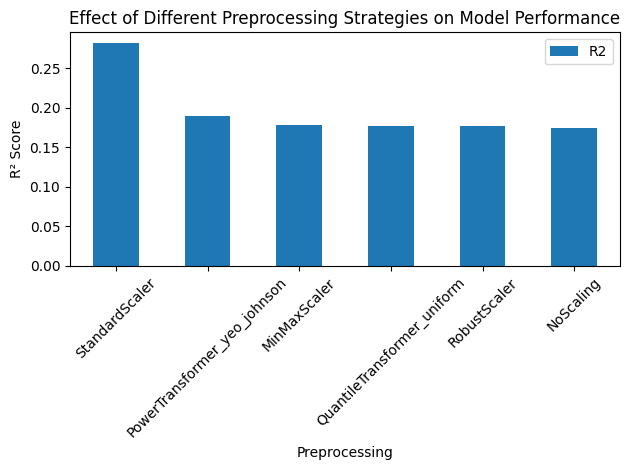

In [10]:
results_df.plot(x="Preprocessing", y="R2", kind="bar", rot=45)
plt.ylabel("R² Score")
plt.title("Effect of Different Preprocessing Strategies on Model Performance")
plt.tight_layout()
plt.show()

In [11]:
best = results_df.iloc[0]
best

,0
Preprocessing,StandardScaler
MSE,0.067202
RMSE,0.259234
R2,0.281342
